# Phase 2: Formation Transitions

**Prerequisite**: Complete `phase1_line_formation.ipynb` first.

**Goal**: Train the NCA to transition between formations based on spatial guidance.

**Training Coverage**:
- **Formation → Formation** (25 pairs): All pairwise transitions between 5 formations
- **Seed → Formation** (5 pairs): Gaussian blob to any formation (retains Phase 1 capability)

**Formations**:
- Line (horizontal band)
- Phalanx (deep rectangular block)
- Square (hollow defensive square)
- Wedge (triangle/arrow)
- Column (vertical band)

**Key Improvements**:
- **Alpha-only loss**: Focused gradient on shape channel
- **Spatial guidance**: Target alpha broadcast as formation signal
- **Mass conservation**: Maintained during all transitions
- **Mixed pool**: 80% formations + 20% Gaussian seeds

**Success Criteria**:
- Formation→Formation: Avg MSE < 0.02, worst < 0.05
- Seed→Formation: Avg MSE < 0.02, worst < 0.05
- Mass retention > 85% average, > 70% worst case

In [1]:
# Setup
import subprocess
import sys
import os

REPO_URL = "https://github.com/JackHopkins/FormationHNCA.git"

if os.path.exists("/content"):
    REPO_DIR = "/content/FormationHNCA"
elif os.path.exists("/workspace"):
    REPO_DIR = "/workspace/FormationHNCA"
else:
    REPO_DIR = os.path.expanduser("~/FormationHNCA")

if os.path.exists(REPO_DIR):
    print(f"Pulling latest changes in {REPO_DIR}...")
    result = subprocess.run(["git", "-C", REPO_DIR, "pull"], capture_output=True, text=True)
    print(result.stdout or "Already up to date.")
else:
    print(f"Cloning repository to {REPO_DIR}...")
    subprocess.run(["git", "clone", REPO_URL, REPO_DIR], check=True)

os.chdir(REPO_DIR)

print("Installing JAX with CUDA support...")
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "jax[cuda12]"], check=True)

print("Installing battle-nca package...")
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "-e", "."], check=True)

src_path = os.path.join(REPO_DIR, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print(f"\nWorking directory: {os.getcwd()}")
print("Setup complete!")

Pulling latest changes in /workspace/FormationHNCA...
Already up to date.

Installing JAX with CUDA support...
Installing battle-nca package...

Working directory: /workspace/FormationHNCA
Setup complete!


In [2]:
import jax
import gc

gc.collect()
jax.clear_caches()

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")

if jax.devices()[0].platform == 'gpu':
    print("GPU acceleration enabled!")
else:
    print("WARNING: Running on CPU.")

JAX version: 0.8.2
JAX devices: [CudaDevice(id=0)]
GPU acceleration enabled!


In [3]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import time
import pickle
from pathlib import Path

from battle_nca.core import NCA, perceive
from battle_nca.core.nca import create_seed
from battle_nca.hierarchy import ChildNCA, ParentNCA, HierarchicalNCA
from battle_nca.hierarchy.child_nca import create_army_seed, CHILD_CHANNELS
from battle_nca.combat import FormationTargets, create_formation_target, rotate_formation
from battle_nca.combat.formations import FormationTypes
from battle_nca.training import NCAPool, Trainer, TrainingConfig
from battle_nca.training.optimizers import create_optimizer, normalize_gradients

print("All imports successful!")

All imports successful!


## Configuration

In [4]:
GRID_SIZE = 64
NUM_CHANNELS = 24

# RESET: Set True to start Phase 2 from Phase 1 checkpoint
# Set False to resume Phase 2 training
RESET = True

config = TrainingConfig(
    batch_size=16,
    pool_size=1024,
    min_steps=128,
    max_steps=192,
    learning_rate=2e-3,
    gradient_clip=1.0,
    damage_samples=3,
    damage_start_epoch=1000,  # Later damage since transitions are harder
    log_interval=100,
    checkpoint_interval=500
)

PHASE2_EPOCHS = 5000
SEED = 42

# Rotation augmentation
USE_ROTATION_AUGMENTATION = True
ROTATION_CONTINUOUS = True

# Checkpoints
PHASE1_CHECKPOINT = Path('checkpoints/phase1_line.pkl')
PHASE2_CHECKPOINT = Path('checkpoints/phase2_transitions.pkl')
PHASE2_CHECKPOINT.parent.mkdir(exist_ok=True)

print(f"Phase 2: Formation Transitions")
print(f"Task: Formation A -> Formation B (not seed -> formation)")
print(f"Steps per transition: {config.min_steps}-{config.max_steps}")

Phase 2: Formation Transitions
Task: Formation A -> Formation B (not seed -> formation)
Steps per transition: 128-192


## Load Phase 1 Model

In [5]:
child_nca = ChildNCA(
    num_channels=NUM_CHANNELS,
    hidden_dim=128,
    fire_rate=0.5,
    use_circular_padding=True
)

# Seed for initialization only
seed = create_army_seed(
    height=GRID_SIZE,
    width=GRID_SIZE,
    team_color=(1.0, 0.0, 0.0),
    unit_type=0,
    formation_id=0,
    spawn_region=(GRID_SIZE//2 - 2, GRID_SIZE//2 + 2, GRID_SIZE//2 - 2, GRID_SIZE//2 + 2)
)

print(f"Seed shape: {seed.shape}")

Seed shape: (64, 64, 24)


In [6]:
key = jax.random.PRNGKey(SEED)
key, init_key = jax.random.split(key)

def count_params(params):
    return sum(p.size for p in jax.tree_util.tree_leaves(params))

if RESET:
    if PHASE1_CHECKPOINT.exists():
        print(f"Loading Phase 1 checkpoint from {PHASE1_CHECKPOINT}...")
        with open(PHASE1_CHECKPOINT, 'rb') as f:
            loaded_checkpoint = pickle.load(f)
        params = loaded_checkpoint['params']
        print(f"  Loaded Phase 1 model with {count_params(params):,} parameters")
        print(f"  Phase 1 best loss: {loaded_checkpoint['metrics'].get('best_loss', 'N/A')}")
    else:
        print("ERROR: Phase 1 checkpoint not found!")
        print("Please run phase1_line_formation.ipynb first.")
        raise FileNotFoundError(f"Missing: {PHASE1_CHECKPOINT}")
else:
    if PHASE2_CHECKPOINT.exists():
        print(f"Loading Phase 2 checkpoint from {PHASE2_CHECKPOINT}...")
        with open(PHASE2_CHECKPOINT, 'rb') as f:
            loaded_checkpoint = pickle.load(f)
        params = loaded_checkpoint['params']
        epochs_done = len(loaded_checkpoint['metrics'].get('losses', []))
        print(f"  Loaded Phase 2 model, {epochs_done} epochs done")
    else:
        print("No Phase 2 checkpoint. Loading Phase 1...")
        with open(PHASE1_CHECKPOINT, 'rb') as f:
            loaded_checkpoint = pickle.load(f)
        params = loaded_checkpoint['params']

print(f"Total parameters: {count_params(params):,}")

Loading Phase 1 checkpoint from checkpoints/phase1_line.pkl...
  Loaded Phase 1 model with 36,466 parameters
  Phase 1 best loss: 0.023444703954737633
Total parameters: 36,466


## Create Formation Targets

In [ ]:
# Create formation targets
# Note: rotation_safe parameter requires updated formations.py
# For now, use default parameters (formations may clip at extreme rotations)
targets = {
    'line': FormationTargets.line(GRID_SIZE, GRID_SIZE),
    'phalanx': FormationTargets.phalanx(GRID_SIZE, GRID_SIZE, depth=8),
    'square': FormationTargets.square(GRID_SIZE, GRID_SIZE, thickness=3),
    'wedge': FormationTargets.wedge(GRID_SIZE, GRID_SIZE),
    'column': FormationTargets.column(GRID_SIZE, GRID_SIZE, col_width=4),
}

formation_names = list(targets.keys())
num_formations = len(formation_names)

# Visualize base formations and rotated versions
fig, axes = plt.subplots(2, num_formations, figsize=(3*num_formations, 6))
for idx, (name, target) in enumerate(targets.items()):
    # Base formation
    axes[0, idx].imshow(target[..., 3], cmap='gray', vmin=0, vmax=1)
    axes[0, idx].set_title(f'{name}\n(base)')
    axes[0, idx].axis('off')
    
    # Rotated 45° (worst case for clipping)
    rotated = rotate_formation(target, np.pi/4)
    axes[1, idx].imshow(rotated[..., 3], cmap='gray', vmin=0, vmax=1)
    axes[1, idx].set_title(f'rotated 45°')
    axes[1, idx].axis('off')

plt.suptitle('Formation Targets (base and rotated 45°)', fontsize=14)
plt.tight_layout()
plt.show()

print(f"Created {num_formations} formation targets")
print(f"Note: Large formations may clip at extreme rotation angles")

## Create Mixed Training Pool

The pool contains both established formations AND Gaussian seeds:
- **80% formations**: For Formation A → Formation B transitions
- **20% Gaussian seeds**: For Seed → Formation transitions (Phase 1 capability)

Each training iteration will:
1. Sample a starting state (formation OR seed)
2. Pick a target formation
3. Train the NCA to transition while conserving mass

This ensures the model can:
- Transform between any pair of formations
- Form any shape from a dispersed blob (robust to damage)

In [8]:
def create_formation_state(target, key):
    """Create an NCA state from a formation target.
    
    Converts the target pattern into a full 24-channel state with:
    - RGB from target
    - Alpha from target
    - Other channels initialized appropriately
    """
    state = jnp.zeros((GRID_SIZE, GRID_SIZE, NUM_CHANNELS))
    
    # Copy RGBA from target
    state = state.at[..., :4].set(target[..., :4])
    
    # Initialize health where alpha > 0
    alive = target[..., 3] > 0.1
    state = state.at[..., 4].set(jnp.where(alive, 1.0, 0.0))  # Health
    state = state.at[..., 5].set(jnp.where(alive, 1.0, 0.0))  # Morale
    
    # Small random noise in hidden channels for diversity
    noise = jax.random.uniform(key, (GRID_SIZE, GRID_SIZE, 9), minval=-0.1, maxval=0.1)
    state = state.at[..., 15:24].set(noise)
    
    return state


def create_gaussian_seed(height, width, num_channels, target_mass, key, sigma=10.0):
    """Create a Gaussian blob seed with specified total mass.
    
    Same as Phase 1 - blob centered in grid with alpha values scaled
    so total mass equals target_mass.
    """
    state = jnp.zeros((height, width, num_channels))
    
    # Create Gaussian blob centered in grid
    cy, cx = height // 2, width // 2
    y = jnp.arange(height)
    x = jnp.arange(width)
    yy, xx = jnp.meshgrid(y, x, indexing='ij')
    
    # Gaussian distribution
    dist_sq = (yy - cy) ** 2 + (xx - cx) ** 2
    gaussian = jnp.exp(-dist_sq / (2 * sigma ** 2))
    
    # Scale to match target mass
    current_mass = jnp.sum(gaussian)
    alpha = gaussian * (target_mass / current_mass)
    alpha = jnp.clip(alpha, 0.0, 1.0)
    
    # Set RGBA channels
    state = state.at[..., 0].set(1.0)  # R (team color)
    state = state.at[..., 1].set(0.0)  # G
    state = state.at[..., 2].set(0.0)  # B
    state = state.at[..., 3].set(alpha)  # Alpha = density
    
    # Initialize other channels where alpha > threshold
    alive = alpha > 0.1
    state = state.at[..., CHILD_CHANNELS.HEALTH].set(jnp.where(alive, 1.0, 0.0))
    state = state.at[..., CHILD_CHANNELS.MORALE].set(jnp.where(alive, 0.5, 0.0))
    
    # Small noise in hidden channels
    key, subkey = jax.random.split(key)
    hidden_noise = jax.random.uniform(subkey, (height, width, 9), minval=-0.1, maxval=0.1)
    state = state.at[..., CHILD_CHANNELS.HIDDEN_START:CHILD_CHANNELS.HIDDEN_END].set(
        jnp.where(alive[..., None], hidden_noise, 0.0)
    )
    
    return state


# Compute reference mass from line formation (all formations should have similar mass)
REFERENCE_MASS = float(jnp.sum(targets['line'][..., 3]))

# Pool composition: 80% formations, 20% Gaussian seeds
SEED_FRACTION = 0.2
SEED_ID = num_formations  # Use index beyond formations to mark seeds


def create_transition_pool(pool_size, key):
    """Create a pool for transition training.
    
    Pool contains:
    - 80% established formations (for Formation A -> Formation B)
    - 20% Gaussian seeds (for Seed -> Formation, like Phase 1)
    
    This ensures the model retains seed->formation capability
    and is robust to heavily damaged/dispersed states.
    """
    pool_states = []
    pool_formation_ids = []  # Track which formation each state is (SEED_ID for seeds)
    
    num_seeds = int(pool_size * SEED_FRACTION)
    num_formations_samples = pool_size - num_seeds
    samples_per_formation = num_formations_samples // num_formations
    
    # Add established formations (80%)
    for formation_idx, name in enumerate(formation_names):
        target = targets[name]
        
        for i in range(samples_per_formation):
            key, subkey1, subkey2 = jax.random.split(key, 3)
            
            # Random rotation for variety
            if USE_ROTATION_AUGMENTATION:
                angle = float(jax.random.uniform(subkey1, (), minval=0, maxval=2*jnp.pi))
                rotated_target = rotate_formation(target, angle)
            else:
                rotated_target = target
            
            state = create_formation_state(rotated_target, subkey2)
            pool_states.append(state)
            pool_formation_ids.append(formation_idx)
    
    # Add Gaussian seeds (20%)
    for i in range(num_seeds):
        key, subkey = jax.random.split(key)
        # Vary sigma for different spread levels
        sigma = float(jax.random.uniform(subkey, (), minval=6.0, maxval=14.0))
        key, subkey = jax.random.split(key)
        state = create_gaussian_seed(GRID_SIZE, GRID_SIZE, NUM_CHANNELS, REFERENCE_MASS, subkey, sigma=sigma)
        pool_states.append(state)
        pool_formation_ids.append(SEED_ID)  # Mark as seed
    
    # Fill remaining slots with formations
    remaining = pool_size - len(pool_states)
    for i in range(remaining):
        key, subkey1, subkey2 = jax.random.split(key, 3)
        formation_idx = i % num_formations
        target = targets[formation_names[formation_idx]]
        
        if USE_ROTATION_AUGMENTATION:
            angle = float(jax.random.uniform(subkey1, (), minval=0, maxval=2*jnp.pi))
            rotated_target = rotate_formation(target, angle)
        else:
            rotated_target = target
        
        state = create_formation_state(rotated_target, subkey2)
        pool_states.append(state)
        pool_formation_ids.append(formation_idx)
    
    return jnp.stack(pool_states), jnp.array(pool_formation_ids)


key, pool_key = jax.random.split(key)
transition_pool, pool_formation_ids = create_transition_pool(config.pool_size, pool_key)

print(f"Created transition pool: {transition_pool.shape}")
print(f"Reference mass: {REFERENCE_MASS:.0f}")
print(f"\nPool composition:")
for i, name in enumerate(formation_names):
    count = int(jnp.sum(pool_formation_ids == i))
    print(f"  {name}: {count}")
seed_count = int(jnp.sum(pool_formation_ids == SEED_ID))
print(f"  gaussian_seed: {seed_count} ({seed_count/config.pool_size:.0%})")

Created transition pool: (1024, 64, 64, 24)
Reference mass: 78

Pool composition:
  line: 164
  phalanx: 164
  square: 164
  wedge: 164
  column: 164
  gaussian_seed: 204 (20%)


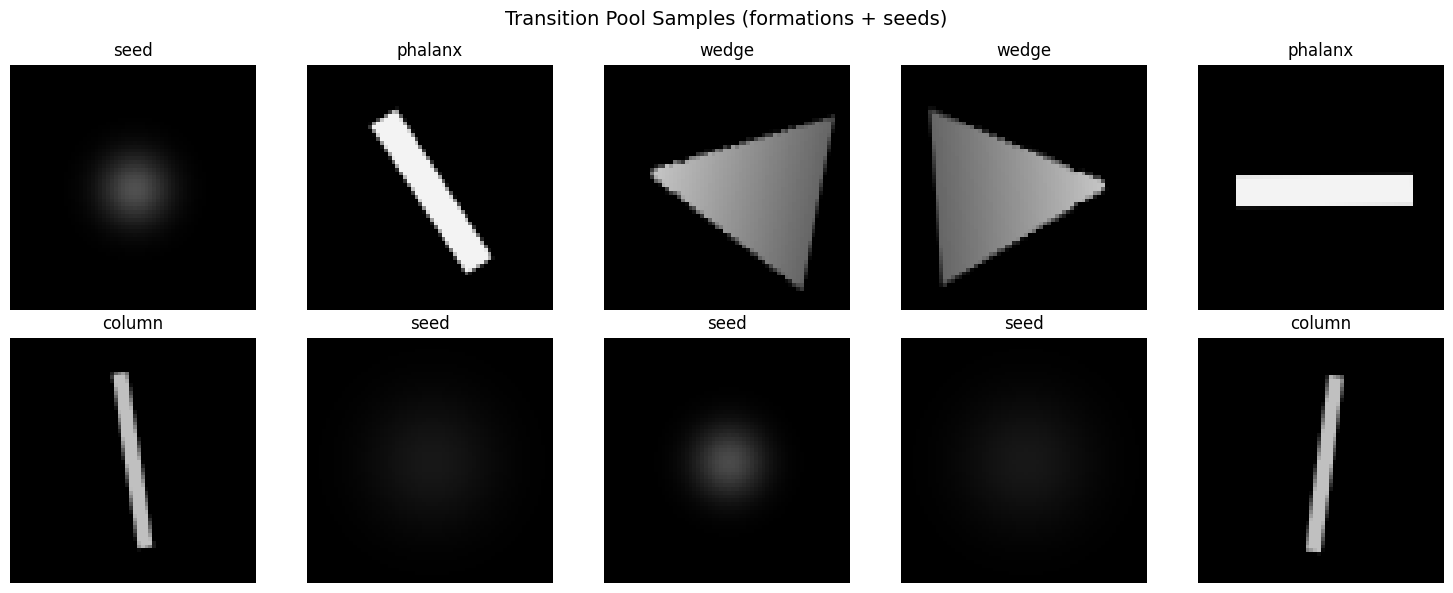

In [9]:
# Visualize samples from the transition pool
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

key, viz_key = jax.random.split(key)
sample_indices = jax.random.permutation(viz_key, config.pool_size)[:10]

# Extended names for display (includes seed)
display_names = formation_names + ['seed']

for i, idx in enumerate(sample_indices):
    row, col = i // 5, i % 5
    state = transition_pool[idx]
    formation_id = int(pool_formation_ids[idx])
    
    # Handle seed ID
    name = display_names[formation_id] if formation_id < len(display_names) else 'seed'
    
    axes[row, col].imshow(state[..., 3], cmap='gray', vmin=0, vmax=1)
    axes[row, col].set_title(f'{name}')
    axes[row, col].axis('off')

plt.suptitle('Transition Pool Samples (formations + seeds)', fontsize=14)
plt.tight_layout()
plt.show()

## Training Setup

In [10]:
optimizer = create_optimizer(
    learning_rate=config.learning_rate,
    gradient_clip=config.gradient_clip
)

state = train_state.TrainState.create(
    apply_fn=child_nca.apply,
    params=params,
    tx=optimizer
)

print(f"Optimizer ready")

Optimizer ready


In [ ]:
# Training step with GRADIENT ACCUMULATION for stable loss landscape
# 1. Fixed num_steps to avoid recompilation
# 2. Vectorized checkpoint computation
# 3. Alpha-only loss for focused gradient signal
# 4. Spatial guidance via target alpha + GRADIENTS (orientation info)
# 5. Gradient accumulation over multiple micro-batches

NUM_CHECKPOINTS = 4
MASS_CONSERVATION_WEIGHT = 0.5

# FIX: Use fixed step count to avoid JIT recompilation
FIXED_NUM_STEPS = 256

# === GRADIENT ACCUMULATION CONFIG ===
ACCUM_STEPS = 4  # Accumulate gradients over 4 micro-batches
# Effective batch size = config.batch_size * ACCUM_STEPS

# Number of channels in formation signal (expanded for orientation)
# Note: Model was trained with 2 channels, so we only pass first 2 to model
# Full 4-channel signal is available for future architecture updates
SIGNAL_CHANNELS = 4  # [target_alpha, grad_x, grad_y, reserved]
MODEL_SIGNAL_CHANNELS = 2  # Channels actually passed to model (backward compatible)


def compute_target_gradients(target_alpha):
    """Compute Sobel gradients of target alpha for orientation information.
    
    Returns:
        grad_x: Horizontal gradient (positive = target extends right)
        grad_y: Vertical gradient (positive = target extends down)
    """
    sobel_x = jnp.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=jnp.float32)
    sobel_y = sobel_x.T
    
    # Pad with wrap for toroidal topology
    target_padded = jnp.pad(target_alpha, ((1, 1), (1, 1)), mode='wrap')
    
    # Compute gradients via convolution
    # Need to reshape for conv: (H, W) -> (1, H, W, 1)
    target_4d = target_padded[None, :, :, None]
    
    grad_x = jax.lax.conv_general_dilated(
        target_4d, 
        sobel_x[:, :, None, None],
        (1, 1), 
        'VALID', 
        dimension_numbers=('NHWC', 'HWIO', 'NHWC')
    )[0, :, :, 0]
    
    grad_y = jax.lax.conv_general_dilated(
        target_4d, 
        sobel_y[:, :, None, None],
        (1, 1), 
        'VALID', 
        dimension_numbers=('NHWC', 'HWIO', 'NHWC')
    )[0, :, :, 0]
    
    return grad_x, grad_y


def create_formation_signal_spatial(batch_size, height, width, target_alpha):
    """Create goal-conditioning signal with target alpha AND gradients.
    
    Each cell receives:
    - Channel 0: Target alpha at its position (density goal)
    - Channel 1: Target gradient X (horizontal direction to grow)
    - Channel 2: Target gradient Y (vertical direction to grow)
    - Channel 3: Reserved (set to 0)
    
    Note: Current model only uses first 2 channels (alpha, grad_x).
    Full signal is computed for future architecture updates.
    """
    # Compute target gradients for orientation
    grad_x, grad_y = compute_target_gradients(target_alpha)
    
    # Normalize gradients to [-1, 1] range for stable learning
    grad_magnitude = jnp.sqrt(grad_x**2 + grad_y**2 + 1e-8)
    max_mag = jnp.max(grad_magnitude)
    grad_x_norm = grad_x / (max_mag + 1e-8)
    grad_y_norm = grad_y / (max_mag + 1e-8)
    
    signal = jnp.zeros((batch_size, height, width, SIGNAL_CHANNELS))
    signal = signal.at[..., 0].set(target_alpha)    # Target density
    signal = signal.at[..., 1].set(grad_x_norm)     # Normalized gradient X
    signal = signal.at[..., 2].set(grad_y_norm)     # Normalized gradient Y
    signal = signal.at[..., 3].set(0.0)             # Reserved
    return signal


@jax.jit
def compute_grads(params, batch, target, key, formation_signal, initial_mass):
    """Compute gradients for a single micro-batch WITHOUT applying them.
    
    This is the core of gradient accumulation - we compute gradients separately
    from applying them, allowing accumulation over multiple batches.
    """
    num_steps = FIXED_NUM_STEPS
    
    def loss_fn(params):
        keys = jax.random.split(key, num_steps)
        
        checkpoint_interval = num_steps // NUM_CHECKPOINTS
        
        def step(carry, inputs):
            step_idx, subkey = inputs
            # Write first 2 channels to state (backward compatible with channel layout)
            state_in = carry.at[..., CHILD_CHANNELS.PARENT_SIGNAL_START:CHILD_CHANNELS.PARENT_SIGNAL_END].set(
                formation_signal[..., :2]
            )
            # Pass only first 2 channels to model (backward compatible with Phase 1 checkpoint)
            # Model expects 2-channel parent_signal
            new_state = child_nca.apply(
                {'params': params}, state_in, subkey, parent_signal=formation_signal[..., :MODEL_SIGNAL_CHANNELS]
            )
            return new_state, new_state
        
        step_inputs = (jnp.arange(num_steps), keys)
        final, all_states = jax.lax.scan(step, batch, step_inputs)
        
        # === VECTORIZED checkpoint extraction ===
        checkpoint_indices = jnp.array([
            checkpoint_interval - 1,
            2 * checkpoint_interval - 1,
            3 * checkpoint_interval - 1,
            4 * checkpoint_interval - 1
        ])
        checkpoint_indices = jnp.minimum(checkpoint_indices, num_steps - 1)
        checkpoint_states = all_states[checkpoint_indices]
        
        # === ALPHA-ONLY formation loss (focused gradient signal) ===
        checkpoint_errors = (checkpoint_states[..., 3:4] - target[..., 3:4]) ** 2
        checkpoint_mses = jnp.mean(checkpoint_errors, axis=(1, 2, 3, 4))
        checkpoint_weights = jnp.array([0.1, 0.2, 0.3, 0.4])
        formation_loss = jnp.sum(checkpoint_weights * checkpoint_mses)
        
        # === VECTORIZED mass conservation loss ===
        checkpoint_masses = jnp.sum(checkpoint_states[..., 3], axis=(2, 3))
        relative_errors = jnp.abs(checkpoint_masses - initial_mass[None, :]) / (initial_mass[None, :] + 1e-6)
        mass_conservation_loss = jnp.mean(relative_errors)
        
        total_loss = formation_loss + MASS_CONSERVATION_WEIGHT * mass_conservation_loss
        return total_loss, (final, formation_loss, mass_conservation_loss)
    
    (loss, (outputs, form_loss, mass_loss)), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
    return grads, loss, outputs, form_loss, mass_loss


@jax.jit
def apply_accumulated_grads(state, accumulated_grads, accum_steps):
    """Apply accumulated gradients after averaging."""
    # Average the accumulated gradients
    avg_grads = jax.tree_util.tree_map(lambda g: g / accum_steps, accumulated_grads)
    # Normalize gradients
    avg_grads = normalize_gradients(avg_grads)
    # Apply gradients
    state = state.apply_gradients(grads=avg_grads)
    return state


def accumulate_grads(grads1, grads2):
    """Add two gradient pytrees together."""
    return jax.tree_util.tree_map(lambda g1, g2: g1 + g2, grads1, grads2)


def zero_grads_like(params):
    """Create a zero gradient pytree with same structure as params."""
    return jax.tree_util.tree_map(jnp.zeros_like, params)


# Visualize the gradient signal for one formation
print("Visualizing target gradients for orientation signal...")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for idx, (name, target) in enumerate(targets.items()):
    # Create signal for this target
    test_signal = create_formation_signal_spatial(1, GRID_SIZE, GRID_SIZE, target[..., 3])
    
    # Top row: target alpha
    axes[0, idx].imshow(test_signal[0, ..., 0], cmap='gray', vmin=0, vmax=1)
    axes[0, idx].set_title(f'{name}\n(target alpha)')
    axes[0, idx].axis('off')
    
    # Bottom row: gradient direction as HSV (hue = direction, saturation = magnitude)
    grad_x = test_signal[0, ..., 1]
    grad_y = test_signal[0, ..., 2]
    angle = np.arctan2(np.array(grad_y), np.array(grad_x))
    magnitude = np.sqrt(np.array(grad_x)**2 + np.array(grad_y)**2)
    
    # Create HSV image
    hsv = np.zeros((GRID_SIZE, GRID_SIZE, 3))
    hsv[..., 0] = (angle + np.pi) / (2 * np.pi)  # Hue: direction
    hsv[..., 1] = np.clip(magnitude * 2, 0, 1)    # Saturation: magnitude
    hsv[..., 2] = np.clip(magnitude * 2, 0, 1)    # Value: magnitude
    
    from matplotlib.colors import hsv_to_rgb
    rgb = hsv_to_rgb(hsv)
    axes[1, idx].imshow(rgb)
    axes[1, idx].set_title(f'gradient direction\n(color=angle)')
    axes[1, idx].axis('off')

plt.suptitle('Formation Signal: Alpha + Gradient Direction (Orientation Info)', fontsize=14)
plt.tight_layout()
plt.show()

print("\nTraining step ready with GRADIENT ACCUMULATION + ORIENTATION.")
print(f"  - Micro-batch size: {config.batch_size}")
print(f"  - Accumulation steps: {ACCUM_STEPS}")
print(f"  - Effective batch size: {config.batch_size * ACCUM_STEPS}")
print(f"  - Fixed NCA steps: {FIXED_NUM_STEPS}")
print(f"  - Signal channels: {SIGNAL_CHANNELS} (alpha, grad_x, grad_y, reserved)")
print(f"  - Model signal channels: {MODEL_SIGNAL_CHANNELS} (backward compatible)")
print(f"  - Alpha-only loss (focused gradient)")
print(f"  - Spatial guidance via target alpha + gradients (ORIENTATION)")
print(f"  - Mass conservation weight: {MASS_CONSERVATION_WEIGHT}")

## Phase 2 Training: Formation Transitions

In [12]:
print("="*60)
print("PHASE 2: Formation Transitions")
print("="*60)
print(f"Task: Start from Formation A (or seed), transition to Formation B")
print(f"Formations: {formation_names}")
print(f"Pool: {100*(1-SEED_FRACTION):.0f}% formations, {100*SEED_FRACTION:.0f}% Gaussian seeds")
print(f"Fixed steps per iteration: {FIXED_NUM_STEPS}")
print(f"Gradient accumulation: {ACCUM_STEPS} micro-batches (effective batch size = {config.batch_size * ACCUM_STEPS})")
print(f"Using spatial guidance (target alpha broadcast)")
print()

PATIENCE = 2000
MIN_DELTA = 1e-6
VIZ_INTERVAL = 500  # Less frequent visualization with gradient accumulation

losses = []
form_losses = []
mass_losses = []
times = []
transition_history = []
best_loss = float('inf')
best_params = state.params
epochs_without_improvement = 0

# Mutable pool
current_pool = transition_pool.copy()
current_pool_ids = pool_formation_ids.copy()

# Extended formation names to include seed
extended_names = formation_names + ['seed']

print("Compiling JIT (first epoch will be slow)...")

for epoch in range(PHASE2_EPOCHS):
    start_time = time.time()
    key, epoch_key = jax.random.split(key)
    
    # Pick a TARGET formation for this epoch (same target for all micro-batches)
    epoch_key, target_key, angle_key = jax.random.split(epoch_key, 3)
    target_idx = int(jax.random.randint(target_key, (), 0, num_formations))
    target = targets[formation_names[target_idx]]
    
    # Rotation augmentation for target
    if USE_ROTATION_AUGMENTATION:
        if ROTATION_CONTINUOUS:
            angle = float(jax.random.uniform(angle_key, (), minval=0, maxval=2 * jnp.pi))
        else:
            angle = float(jax.random.randint(angle_key, (), 0, 4)) * (jnp.pi / 2)
        target = rotate_formation(target, angle)
    else:
        angle = 0.0
    
    # === GRADIENT ACCUMULATION ===
    # Accumulate gradients over multiple micro-batches for stable loss landscape
    accumulated_grads = zero_grads_like(state.params)
    total_loss = 0.0
    total_form_loss = 0.0
    total_mass_loss = 0.0
    all_outputs = []
    all_indices = []
    all_source_formations = []
    batch_mass_before_sum = 0.0
    batch_mass_after_sum = 0.0
    
    for accum_idx in range(ACCUM_STEPS):
        # Sample a new micro-batch for each accumulation step
        epoch_key, sample_key, step_key = jax.random.split(epoch_key, 3)
        batch_indices = jax.random.permutation(sample_key, config.pool_size)[:config.batch_size]
        batch = current_pool[batch_indices]
        batch_source_formations = current_pool_ids[batch_indices]
        
        # Compute initial mass for mass conservation
        initial_mass = jnp.sum(batch[..., 3], axis=(1, 2))  # (B,)
        batch_mass_before_sum += float(jnp.mean(initial_mass))
        
        # Use SPATIAL GUIDANCE: target alpha broadcast to all cells
        formation_signal = create_formation_signal_spatial(
            config.batch_size, GRID_SIZE, GRID_SIZE, target[..., 3]
        )
        
        # Compute gradients for this micro-batch (without applying)
        grads, loss, outputs, form_loss, mass_loss = compute_grads(
            state.params, batch, target, step_key, formation_signal, initial_mass
        )
        
        # Accumulate gradients
        accumulated_grads = accumulate_grads(accumulated_grads, grads)
        
        # Track losses (average over accum steps)
        total_loss += float(loss)
        total_form_loss += float(form_loss)
        total_mass_loss += float(mass_loss)
        
        # Track outputs for pool update
        all_outputs.append(outputs)
        all_indices.append(batch_indices)
        all_source_formations.append(batch_source_formations)
        batch_mass_after_sum += float(jnp.mean(jnp.sum(outputs[..., 3], axis=(1, 2))))
    
    # Average the metrics
    avg_loss = total_loss / ACCUM_STEPS
    avg_form_loss = total_form_loss / ACCUM_STEPS
    avg_mass_loss = total_mass_loss / ACCUM_STEPS
    avg_mass_before = batch_mass_before_sum / ACCUM_STEPS
    avg_mass_after = batch_mass_after_sum / ACCUM_STEPS
    mass_retention = avg_mass_after / (avg_mass_before + 1e-6)
    
    # Apply accumulated (and averaged) gradients
    state = apply_accumulated_grads(state, accumulated_grads, ACCUM_STEPS)
    
    # Visualization (less frequent with gradient accumulation)
    if epoch % VIZ_INTERVAL == 0 and epoch > 0:
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        
        # Use first micro-batch for visualization
        start_alpha = np.array(all_outputs[0][0, ..., 3])
        source_id = int(all_source_formations[0][0])
        source_name = extended_names[source_id] if source_id < len(extended_names) else 'seed'
        axes[0].imshow(start_alpha, cmap='gray', vmin=0, vmax=1)
        axes[0].set_title(f'Output sample\n(mass: {np.sum(start_alpha):.0f})')
        axes[0].axis('off')
        
        axes[1].imshow(np.array(target[..., 3]), cmap='gray', vmin=0, vmax=1)
        axes[1].set_title(f'Target: {formation_names[target_idx]}\n(angle: {np.degrees(angle):.0f}°)')
        axes[1].axis('off')
        
        axes[2].text(0.5, 0.5, f"Transition\nto\n{formation_names[target_idx]}", 
                     ha='center', va='center', fontsize=16)
        axes[2].set_title('Task')
        axes[2].axis('off')
        
        pool_masses = [float(jnp.sum(current_pool[i, ..., 3])) for i in range(min(64, config.pool_size))]
        axes[3].hist(pool_masses, bins=20, color='steelblue', edgecolor='black')
        axes[3].set_xlabel('Mass')
        axes[3].set_title('Pool Health')
        
        plt.suptitle(f'Epoch {epoch} | Best: {best_loss:.6f}')
        plt.tight_layout()
        plt.show()
    
    # Check for NaN/Inf
    if np.isnan(avg_loss) or np.isinf(avg_loss):
        print(f"\nEarly stopping at epoch {epoch}: loss is {avg_loss}")
        state = state.replace(params=best_params)
        break
    
    # Track best model
    if avg_loss < best_loss - MIN_DELTA:
        best_loss = avg_loss
        best_params = state.params
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= PATIENCE:
        print(f"\nEarly stopping at epoch {epoch}: no improvement for {PATIENCE} epochs")
        state = state.replace(params=best_params)
        break
    
    # Pool update: use outputs from ALL micro-batches
    for outputs, batch_indices, batch_source_formations in zip(all_outputs, all_indices, all_source_formations):
        per_sample_losses = jnp.mean((outputs[..., 3:4] - target[..., 3:4]) ** 2, axis=(1, 2, 3))
        current_pool = current_pool.at[batch_indices].set(outputs)
        current_pool_ids = current_pool_ids.at[batch_indices].set(target_idx)
    
    elapsed = time.time() - start_time
    losses.append(avg_loss)
    form_losses.append(avg_form_loss)
    mass_losses.append(avg_mass_loss)
    times.append(elapsed)
    
    # Track transition history from first micro-batch
    source_formation = int(all_source_formations[0][0])
    transition_history.append((source_formation, target_idx))
    
    if epoch % config.log_interval == 0:
        src = extended_names[source_formation] if source_formation < len(extended_names) else 'seed'
        tgt = formation_names[target_idx]
        print(f"Epoch {epoch:4d}: loss={avg_loss:.6f} (form:{avg_form_loss:.6f}, mass:{avg_mass_loss:.4f}), " +
              f"retention={mass_retention:.1%}, {src}->{tgt}, {elapsed:.2f}s")

print(f"\nPhase 2 complete. Best loss: {best_loss:.6f}")
if len(times) > 1:
    print(f"Average time per epoch (after JIT): {np.mean(times[1:]):.3f}s")

PHASE 2: Formation Transitions
Task: Start from Formation A (or seed), transition to Formation B
Formations: ['line', 'phalanx', 'square', 'wedge', 'column']
Pool: 80% formations, 20% Gaussian seeds
Fixed steps per iteration: 256
Gradient accumulation: 4 micro-batches (effective batch size = 64)
Using spatial guidance (target alpha broadcast)

Compiling JIT (first epoch will be slow)...


ScopeParamShapeError: For parameter "kernel" in "/update_rule/combat_h1", the given initializer is expected to generate shape (1, 1, 76, 64), but the existing parameter it received has shape (1, 1, 74, 64). (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ScopeParamShapeError)

## Training Curves

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

window = 100

# Total loss
axes[0, 0].plot(losses, alpha=0.3)
if len(losses) > window:
    smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')
    axes[0, 0].plot(range(window-1, len(losses)), smoothed, 'r-', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Total Loss')
axes[0, 0].set_title('Total Loss')
axes[0, 0].set_yscale('log')

# Formation loss
axes[0, 1].plot(form_losses, alpha=0.3, color='blue')
if len(form_losses) > window:
    smoothed = np.convolve(form_losses, np.ones(window)/window, mode='valid')
    axes[0, 1].plot(range(window-1, len(form_losses)), smoothed, 'b-', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Formation Loss')
axes[0, 1].set_title('Formation Loss (alpha-only)')
axes[0, 1].set_yscale('log')

# Mass conservation
axes[1, 0].plot(mass_losses, alpha=0.3, color='green')
if len(mass_losses) > window:
    smoothed = np.convolve(mass_losses, np.ones(window)/window, mode='valid')
    axes[1, 0].plot(range(window-1, len(mass_losses)), smoothed, 'g-', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Mass Conservation Error')
axes[1, 0].set_title('Mass Conservation Loss')

# Transition matrix (includes seed as source)
extended_names = formation_names + ['seed']
num_extended = len(extended_names)
transition_counts = np.zeros((num_extended, num_formations))  # Source can be seed, target is always formation
for src, tgt in transition_history:
    if src < num_extended and tgt < num_formations:
        transition_counts[src, tgt] += 1

im = axes[1, 1].imshow(transition_counts, cmap='Blues', aspect='auto')
axes[1, 1].set_xticks(range(num_formations))
axes[1, 1].set_yticks(range(num_extended))
axes[1, 1].set_xticklabels(formation_names, rotation=45, ha='right')
axes[1, 1].set_yticklabels(extended_names)
axes[1, 1].set_xlabel('Target')
axes[1, 1].set_ylabel('Source')
axes[1, 1].set_title('Transition Counts (includes seed->formation)')
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()

## Save Checkpoint

In [ ]:
checkpoint = {
    'params': state.params,
    'config': {
        'grid_size': GRID_SIZE,
        'num_channels': NUM_CHANNELS,
        'hidden_dim': 128,
        'goal_conditioned': True,
        'phase': 2,
        'task': 'transitions',
        'num_formations': num_formations,
        'formation_names': formation_names,
    },
    'metrics': {
        'losses': losses,
        'form_losses': form_losses,
        'mass_losses': mass_losses,
        'best_loss': best_loss,
        'transition_history': transition_history,
    }
}

with open(PHASE2_CHECKPOINT, 'wb') as f:
    pickle.dump(checkpoint, f)

print(f"Checkpoint saved to {PHASE2_CHECKPOINT}")
print(f"Best loss: {best_loss:.6f}")

---

# Evaluation: Formation Transitions

Test that the model can transition between any pair of formations.

In [ ]:
def run_transition(start_state, params, key, target_alpha, num_steps=150):
    """Run a formation transition using target alpha + gradients as spatial guidance.
    
    Args:
        start_state: Starting formation state
        params: Model parameters
        key: PRNG key
        target_alpha: Target formation's alpha channel (H, W) for spatial guidance
        num_steps: Number of NCA steps
    
    Returns:
        List of states (trajectory)
    """
    # Create 4-channel signal with alpha + gradients (same as training)
    signal = create_formation_signal_spatial(1, GRID_SIZE, GRID_SIZE, target_alpha)
    signal_single = signal[0]
    
    trajectory = [start_state]
    state_curr = start_state
    
    for i in range(num_steps):
        key, subkey = jax.random.split(key)
        # Write first 2 channels to state (backward compatible)
        state_curr = state_curr.at[..., CHILD_CHANNELS.PARENT_SIGNAL_START:CHILD_CHANNELS.PARENT_SIGNAL_END].set(
            signal_single[..., :2]
        )
        # Pass only first 2 channels to model (backward compatible with Phase 1 checkpoint)
        state_curr = child_nca.apply(
            {'params': params}, state_curr, subkey, parent_signal=signal_single[..., :MODEL_SIGNAL_CHANNELS]
        )
        trajectory.append(state_curr)
    
    return trajectory

print("Transition function ready (using spatial guidance with ORIENTATION).")
print(f"  Signal channels: {SIGNAL_CHANNELS} (alpha, grad_x, grad_y, reserved)")
print(f"  Model signal channels: {MODEL_SIGNAL_CHANNELS} (backward compatible)")

In [ ]:
# Test all pairwise transitions (5x5 = 25 pairs) + seed->formation (5 more)
print("Testing all formation transitions...")

transition_mses = np.zeros((num_formations, num_formations))
transition_retentions = np.zeros((num_formations, num_formations))

# Also test seed -> formation
seed_mses = np.zeros(num_formations)
seed_retentions = np.zeros(num_formations)

key, eval_key = jax.random.split(key)

# Formation -> Formation transitions
for src_idx, src_name in enumerate(formation_names):
    # Create starting state from source formation
    eval_key, state_key = jax.random.split(eval_key)
    start_state = create_formation_state(targets[src_name], state_key)
    initial_mass = float(jnp.sum(start_state[..., 3]))
    
    for tgt_idx, tgt_name in enumerate(formation_names):
        eval_key, run_key = jax.random.split(eval_key)
        
        target = targets[tgt_name]
        
        # Run transition with target alpha as spatial guidance
        trajectory = run_transition(start_state, state.params, run_key, target[..., 3], num_steps=150)
        final = trajectory[-1]
        
        # Compute metrics using ALPHA-ONLY MSE
        mse = float(np.mean((np.array(target[..., 3]) - np.array(final[..., 3]))**2))
        final_mass = float(jnp.sum(final[..., 3]))
        retention = final_mass / initial_mass
        
        transition_mses[src_idx, tgt_idx] = mse
        transition_retentions[src_idx, tgt_idx] = retention

# Seed -> Formation transitions
print("Testing seed -> formation transitions...")
for tgt_idx, tgt_name in enumerate(formation_names):
    eval_key, seed_key, run_key = jax.random.split(eval_key, 3)
    
    # Create Gaussian seed
    seed_state = create_gaussian_seed(GRID_SIZE, GRID_SIZE, NUM_CHANNELS, REFERENCE_MASS, seed_key, sigma=10.0)
    initial_mass = float(jnp.sum(seed_state[..., 3]))
    
    target = targets[tgt_name]
    
    # Run transition
    trajectory = run_transition(seed_state, state.params, run_key, target[..., 3], num_steps=150)
    final = trajectory[-1]
    
    # Compute metrics
    mse = float(np.mean((np.array(target[..., 3]) - np.array(final[..., 3]))**2))
    final_mass = float(jnp.sum(final[..., 3]))
    retention = final_mass / initial_mass
    
    seed_mses[tgt_idx] = mse
    seed_retentions[tgt_idx] = retention

print("Done!")

In [ ]:
# Visualize transition matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MSE matrix
im1 = axes[0].imshow(transition_mses, cmap='Reds', vmin=0)
axes[0].set_xticks(range(num_formations))
axes[0].set_yticks(range(num_formations))
axes[0].set_xticklabels(formation_names, rotation=45, ha='right')
axes[0].set_yticklabels(formation_names)
axes[0].set_xlabel('Target Formation')
axes[0].set_ylabel('Source Formation')
axes[0].set_title('Transition MSE (lower is better)')
plt.colorbar(im1, ax=axes[0])

# Add text annotations
for i in range(num_formations):
    for j in range(num_formations):
        axes[0].text(j, i, f'{transition_mses[i,j]:.3f}', ha='center', va='center', fontsize=8)

# Retention matrix
im2 = axes[1].imshow(transition_retentions, cmap='Greens', vmin=0.5, vmax=1.5)
axes[1].set_xticks(range(num_formations))
axes[1].set_yticks(range(num_formations))
axes[1].set_xticklabels(formation_names, rotation=45, ha='right')
axes[1].set_yticklabels(formation_names)
axes[1].set_xlabel('Target Formation')
axes[1].set_ylabel('Source Formation')
axes[1].set_title('Mass Retention (1.0 = perfect)')
plt.colorbar(im2, ax=axes[1])

for i in range(num_formations):
    for j in range(num_formations):
        axes[1].text(j, i, f'{transition_retentions[i,j]:.2f}', ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
# Visualize specific transitions
test_transitions = [
    ('line', 'wedge'),
    ('wedge', 'square'),
    ('square', 'column'),
    ('column', 'phalanx'),
]

fig, axes = plt.subplots(len(test_transitions), 6, figsize=(18, 3*len(test_transitions)))

timesteps = [0, 30, 60, 90, 120, 150]

for row, (src_name, tgt_name) in enumerate(test_transitions):
    src_idx = formation_names.index(src_name)
    tgt_idx = formation_names.index(tgt_name)
    
    eval_key, state_key, run_key = jax.random.split(eval_key, 3)
    start_state = create_formation_state(targets[src_name], state_key)
    target = targets[tgt_name]
    
    # Use target alpha as spatial guidance
    trajectory = run_transition(start_state, state.params, run_key, target[..., 3], num_steps=150)
    
    for col, t in enumerate(timesteps):
        if t < len(trajectory):
            axes[row, col].imshow(trajectory[t][..., 3], cmap='gray', vmin=0, vmax=1)
        axes[row, col].set_title(f't={t}')
        axes[row, col].axis('off')
    
    axes[row, 0].set_ylabel(f'{src_name} -> {tgt_name}', fontsize=10)

plt.suptitle('Formation Transitions Over Time', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Test rotation during transition
print("Testing line -> wedge with different target rotations...")

angles_test = [0, np.pi/4, np.pi/2, np.pi]
angle_labels = ['0°', '45°', '90°', '180°']

fig, axes = plt.subplots(2, len(angles_test), figsize=(3*len(angles_test), 6))

eval_key, state_key = jax.random.split(eval_key)
start_state = create_formation_state(targets['line'], state_key)

for col, (angle, label) in enumerate(zip(angles_test, angle_labels)):
    eval_key, run_key = jax.random.split(eval_key)
    
    # Target wedge at this angle
    rotated_target = rotate_formation(targets['wedge'], float(angle))
    
    # Use rotated target's alpha as spatial guidance
    trajectory = run_transition(start_state, state.params, run_key, rotated_target[..., 3], num_steps=150)
    final = trajectory[-1]
    
    # Target
    axes[0, col].imshow(rotated_target[..., 3], cmap='gray', vmin=0, vmax=1)
    axes[0, col].set_title(f'Target @ {label}')
    axes[0, col].axis('off')
    
    # Result - use alpha-only MSE
    mse = np.mean((np.array(rotated_target[..., 3]) - np.array(final[..., 3]))**2)
    axes[1, col].imshow(final[..., 3], cmap='gray', vmin=0, vmax=1)
    axes[1, col].set_title(f'Result (MSE: {mse:.4f})')
    axes[1, col].axis('off')

plt.suptitle('Line -> Wedge with Rotation', fontsize=14)
plt.tight_layout()
plt.show()

## Success Criteria Check

In [ ]:
print("=" * 60)
print("PHASE 2 SUCCESS CRITERIA: Formation Transitions")
print("=" * 60)
print("(Using alpha-only MSE for shape matching)")

# Analyze transition matrix (formation -> formation)
avg_mse = np.mean(transition_mses)
max_mse = np.max(transition_mses)
avg_retention = np.mean(transition_retentions)
min_retention = np.min(transition_retentions)

# Off-diagonal (actual transitions, not same-to-same)
off_diag_mask = ~np.eye(num_formations, dtype=bool)
avg_transition_mse = np.mean(transition_mses[off_diag_mask])
avg_transition_retention = np.mean(transition_retentions[off_diag_mask])

# Seed -> formation metrics
avg_seed_mse = np.mean(seed_mses)
max_seed_mse = np.max(seed_mses)
avg_seed_retention = np.mean(seed_retentions)
min_seed_retention = np.min(seed_retentions)

print("\n=== Formation -> Formation Metrics (alpha-only) ===")
print(f"  Average MSE (all pairs): {avg_mse:.6f}")
print(f"  Average MSE (transitions only): {avg_transition_mse:.6f}")
print(f"  Worst MSE: {max_mse:.6f}")
print(f"  Average retention: {avg_retention:.1%}")
print(f"  Worst retention: {min_retention:.1%}")

print("\n=== Seed -> Formation Metrics (alpha-only) ===")
print(f"  Average MSE: {avg_seed_mse:.6f}")
print(f"  Worst MSE: {max_seed_mse:.6f}")
print(f"  Average retention: {avg_seed_retention:.1%}")
print(f"  Worst retention: {min_seed_retention:.1%}")

print("\nPer-Transition Analysis (Formation -> Formation):")
for src_idx, src_name in enumerate(formation_names):
    for tgt_idx, tgt_name in enumerate(formation_names):
        if src_idx != tgt_idx:
            mse = transition_mses[src_idx, tgt_idx]
            ret = transition_retentions[src_idx, tgt_idx]
            status = "OK" if mse < 0.02 and ret > 0.85 else "NEEDS WORK"
            print(f"  {src_name:8s} -> {tgt_name:8s}: MSE={mse:.4f}, Retention={ret:.1%} [{status}]")

print("\nPer-Transition Analysis (Seed -> Formation):")
for tgt_idx, tgt_name in enumerate(formation_names):
    mse = seed_mses[tgt_idx]
    ret = seed_retentions[tgt_idx]
    status = "OK" if mse < 0.02 and ret > 0.85 else "NEEDS WORK"
    print(f"  seed     -> {tgt_name:8s}: MSE={mse:.4f}, Retention={ret:.1%} [{status}]")

# Success criteria
print("\n" + "=" * 60)
criteria = [
    ("Avg formation->formation MSE < 0.02", avg_transition_mse, 0.02, avg_transition_mse < 0.02),
    ("Worst formation->formation MSE < 0.05", max_mse, 0.05, max_mse < 0.05),
    ("Avg seed->formation MSE < 0.02", avg_seed_mse, 0.02, avg_seed_mse < 0.02),
    ("Worst seed->formation MSE < 0.05", max_seed_mse, 0.05, max_seed_mse < 0.05),
    ("Avg retention > 85%", min(avg_transition_retention, avg_seed_retention), 0.85, 
     avg_transition_retention > 0.85 and avg_seed_retention > 0.85),
    ("Worst retention > 70%", min(min_retention, min_seed_retention), 0.70, 
     min_retention > 0.70 and min_seed_retention > 0.70),
]

all_passed = True
for name, value, threshold, passed in criteria:
    status = "PASS" if passed else "FAIL"
    print(f"{name}: {value:.4f} (threshold: {threshold}) [{status}]")
    if not passed:
        all_passed = False

print("=" * 60)
if all_passed:
    print("ALL CRITERIA PASSED - Ready for Phase 3!")
    print("\nNext: Implement combat dynamics with adversarial armies")
else:
    print("SOME CRITERIA FAILED - Consider more training")
    print("\nTry: Set RESET=False and run training again")